In [968]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import polars as pl
import numpy as np
from dataclasses import dataclass
import mplhep
mplhep.style.use(mplhep.style.ROOT)

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True
                     })

In [135]:
# with uproot.open('/home/pgranger/atmospherics/sum_50k_hd_AV.root') as f:
file = '/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5/caf_sum.root'
def loadData(file):
    with uproot.open(file) as f:
        tree = f['cafTree']
        tree.show()
        cols = [key for key in tree.keys() if "Jagged" not in str(tree[key].interpretation)]

        data = f['cafTree'].arrays(cols, library='np')
        df = pl.from_pandas(pd.DataFrame(data))
        return df
    # print(df)

df = loadData(file)
dfold = loadData('/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV/caf_sum.root')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.CVNResult0Neu... | float                    | AsDtype('>f4')
rec.CVNResult0Pions  | float                    | AsDtype('>f4')
rec.CVNResult0Piz... | float                    | AsDtype('>f4')
rec.CVNResult0Pro... | float                    | AsDtype('>f4')
rec.CVNResult1Neu... | float                    | AsDtype('>f4')
rec.CVNResult1Pions  | float                    | AsDtype('>f4')
rec.CVNResult1Piz... | float                    | AsDtype('>f4')
rec.CVNResult1Pro... | float                    | AsDtype('>f4')
rec.CVNResult2Neu... | float                    | AsDtype('>f4')
rec.CVNResult2Pions  | float                    | AsDtype('>f4')
rec.CVNResult2Piz... | float                    | AsDtype('>f4')
rec.CVNResult2Pro... | float                    | AsDtype('>f4')
rec.CVNResultIsAn... | float                    | AsDtype(

In [1159]:
pl.Config.set_tbl_rows(20)
@dataclass
class Flavour:
    pdg:int
    name:str
    name_latex:str
    cvn:str

flavours = {
    -16: Flavour(-16, "nutaubar", r"$\overline{\nu}_\tau$", "rec.cvnnutau"),
    -14: Flavour(-14, "numubar", r"$\overline{\nu}_\mu$", "rec.cvnnumu"),
    -12 : Flavour(-12, "nuebar", r"$\overline{\nu}_e$", "rec.cvnnue"),
    12: Flavour(12, "nue", r"$\nu_e$", "rec.cvnnue"),
    14: Flavour(14, "numu", r"$\nu_\mu$", "rec.cvnnumu"),
    16: Flavour(16, "nutau", r"$\nu_\tau$", "rec.cvnnutau")
}

def get_max():
    return  pl.max('rec.cvnnue','rec.cvnnumu','rec.cvnnutau','rec.cvnnc')

def define_flavour(df:pl.DataFrame):
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(0).otherwise(
        pl.when((pl.col('rec.cvnnue') >= 0.5)).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu')>=0.5).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=0.5).then(0).otherwise(16)
        )))
    )
    return df

def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

shape: (34, 12)
┌──────┬───────────┬────────────┬────────────┬────────────┬──────┬────────────┬────────────┬────────────┬────────────┬─────────┬────────────┐
│ Ecut ┆ correct_p ┆ false_posi ┆ incorrect_ ┆ total_even ┆ puri ┆ completene ┆ err_correc ┆ err_false_ ┆ err_incorr ┆ errpuri ┆ errcomplet │
│ ---  ┆ dg        ┆ tive       ┆ pdg        ┆ ts         ┆ ty   ┆ ss         ┆ t_pdg      ┆ positive   ┆ ect_pdg    ┆ ty      ┆ eness      │
│ i16  ┆ ---       ┆ ---        ┆ ---        ┆ ---        ┆ ---  ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---     ┆ ---        │
│      ┆ f64       ┆ f64        ┆ f64        ┆ f64        ┆ f64  ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64     ┆ f64        │
╞══════╪═══════════╪════════════╪════════════╪════════════╪══════╪════════════╪════════════╪════════════╪════════════╪═════════╪════════════╡
│ 0    ┆ 1380.0    ┆ 5.0        ┆ 1453.0     ┆ 2833.0     ┆ 0.99 ┆ 0.487116   ┆ 0.026919   ┆ 0.447214   ┆ 0.026234   ┆ 0.00032 ┆ 0.0

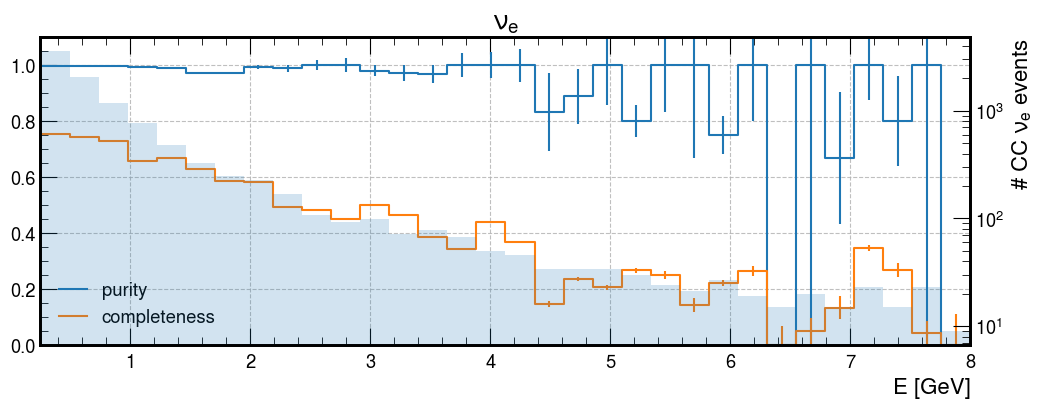

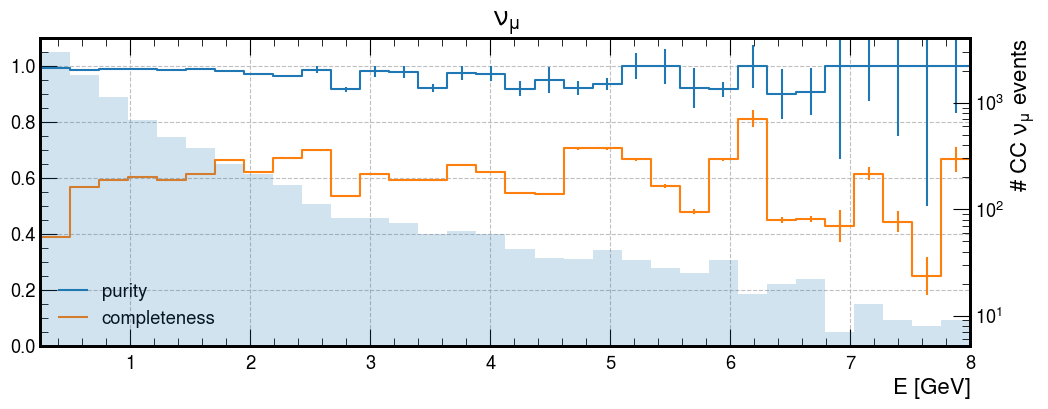

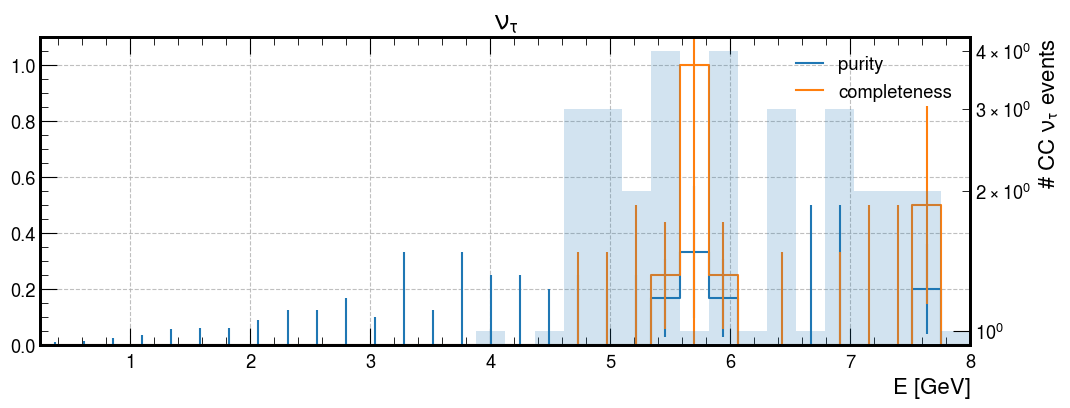

In [1160]:
def purity_evolution(df, Ebins, flavour):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    # df = df.filter(
    #     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
    # )
    cats = df.with_columns(
        Ecut=df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).get_column('category').cast(pl.Int16),
        Ecutt=df.get_column('rec.Ev').cut(Ebins, maintain_order=True).get_column('category')
        )
        
    # print(cats.groupby('Ecutt').agg(pl.col('rec.Ev')).sort('Ecutt'))
    # print(df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).filter(pl.col('rec.Ev')<0.11))
    q = (
        cats.groupby('Ecut').agg(
            nb_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
            nb_other_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).sum(),
            nb_below = pl.col('rec.pot').filter(pl.col(flavour.cvn) < 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
        ).fill_null(0).with_columns(
            err_nb_above = pl.col("nb_above").sqrt(),
            err_nb_other_above = pl.col("nb_other_above").sqrt(),
            err_nb_below = pl.col("nb_below").sqrt(),
            purity = pl.col('nb_above') /
            (pl.col('nb_other_above') + pl.col("nb_above")),
            completeness = pl.col('nb_above') /
            (pl.col('nb_below') + pl.col("nb_above")),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = (pl.col('purity')/pl.col('nb_above')).pow(2)*((pl.col('nb_other_above')*pl.col('err_nb_above')).pow(2) + 
                                                                        (pl.col('nb_above')*pl.col('err_nb_other_above')).pow(2)).sqrt(),
            errcompleteness = (pl.col('completeness')/pl.col('nb_above')).pow(2)*((pl.col('nb_below')*pl.col('err_nb_above')).pow(2) + 
                                                                                    (pl.col('nb_above')*pl.col('err_nb_below')).pow(2)).sqrt(),
        )
    )
    q2 = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            false_positive = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).count().cast(pl.Float64),
            incorrect_pdg = pl.col('rec.pot').filter(pl.col('Flavour') != flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            total_events = pl.col('rec.pot').filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64)

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    # bins_center = (Ebins[1:] + Ebins[:-1])*0.5
    bins_center = Ebins
    bins_width = np.diff(Ebins)
    q = fill_empty_categories(q, labels)
    q2 = fill_empty_categories(q2, labels)
    fig = plt.figure(figsize=(12,4))
    print(q2)
    p = plt.step(bins_center, q2.get_column('purity')[:-1], label='purity')
    # plt.step(bins_center, q.get_column('purity')[:-1], label='purity0')
    c = plt.step(bins_center, q2.get_column('completeness')[:-1], label='completeness')
    # plt.step(bins_center, q.get_column('completeness')[:-1], label='completeness0')

    error_center = (bins_center[1:] + bins_center[:-1])/2
    point_purity = q2.get_column('purity')[1:-1]
    err_purity = q2.get_column('errpurity')[1:-1]
    point_completeness = q2.get_column('completeness')[1:-1]
    err_completeness = q2.get_column('errcompleteness')[1:-1]
    plt.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[0].get_color())
    plt.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[0].get_color())
    plt.title(flavour.name_latex)
    plt.xlabel("E [GeV]")
    plt.xlim(bins_center[0], bins_center[-1])
    plt.ylim(0,1.1)
    plt.legend()
    # plt.xscale('log')
    ax2 = plt.twinx()

    ax2.bar(bins_center[:-1], q2.get_column('total_events')[1:-1], width=bins_width, align="edge", alpha=0.2, log=True)
    ax2.set_ylabel(rf'# CC {flavour.name_latex} events')
    ax2.grid(False)
    # return fig

# Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.25,8,33)
df = define_flavour(df)
dfold = define_flavour(dfold)
purity_evolution(dfold, Ebins, flavours[12]);
purity_evolution(dfold, Ebins, flavours[14]);
purity_evolution(dfold, Ebins, flavours[16]);

In [ ]:

# bins = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnumu'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnumu'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)


# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN numu")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnue'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnue'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nue")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnutau'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnutau'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nutau")


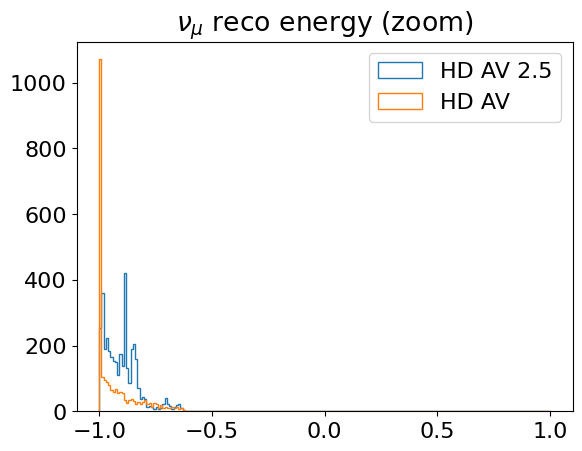

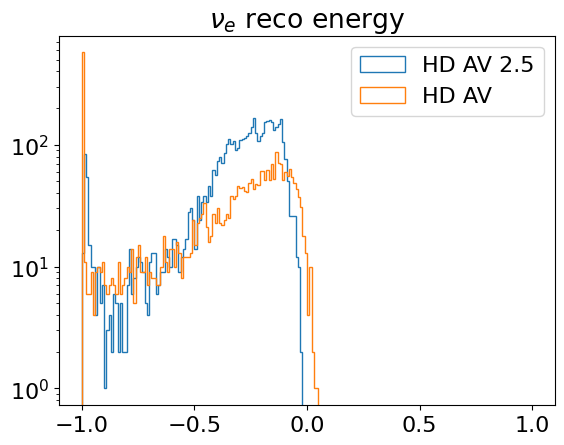

In [318]:

def flavour(pdg):
    return pl.col('rec.nuPDG') == pdg
    # return pl.col('Flavour') == pdg

def energy(pdg):
    En = 'Ev'
    return (pl.col(En) >=1 ) & (pl.col(En) <= 10)
def checkEnergy(df):
    E = df.with_columns(
        Ev = pl.col('rec.Ev'),
        Ev_reco = pl.col('rec.Ev_reco'),
        Ev_reco_nue = pl.col('rec.Ev_reco_nue'),
        Ev_reco_numu = pl.col('rec.Ev_reco_numu')/1000
    ).with_columns(
        Eres = pl.col("Ev_reco")/pl.col("Ev") - 1,
        Eres_nue = pl.col("Ev_reco_nue")/pl.col("Ev") - 1,
        Eres_numu = pl.col("Ev_reco_numu")/pl.col("Ev") - 1,
    )
    return E
E = checkEnergy(df)
Eold = checkEnergy(dfold)
# fig, ax = plt.subplots(1,2,figsize=(14,4))
# ax[0].hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,100), log=True, histtype='step', label='HD AV 2.5');
# ax[0].hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,100), log=True, histtype='step', label='HD AV');
# ax[0].set_title(r'$\nu_\mu$(CC) reco energy')
# ax[0].legend()
plt.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,1), log=False, histtype='step', label='HD AV 2.5');
plt.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,1), log=False, histtype='step', label='HD AV');
plt.title(r'$\nu_\mu$ reco energy (zoom)')
plt.legend()
plt.figure()
plt.hist(E.filter(flavour(12)).filter(energy(12))['Eres_nue'], bins=200, range=(-1, 1),log=True, histtype='step', label='HD AV 2.5');
plt.hist(Eold.filter(flavour(12)).filter(energy(12))['Eres_nue'], bins=200, range=(-1, 1),log=True, histtype='step', label='HD AV');
plt.title(r'$\nu_e$ reco energy')
plt.legend()

shape: (5_593, 7)
┌───────────┬─────────────┬──────────┬─────────────┬───────────────┬───────────────┬───────────────┐
│ rec.event ┆ rec.cvnnumu ┆ rec.Ev   ┆ rec.Ev_reco ┆ rec.Ev_reco_n ┆ rec.Ev_reco_n ┆ rec.muon_cont │
│ ---       ┆ ---         ┆ ---      ┆ ---         ┆ umu           ┆ ue            ┆ ained         │
│ i32       ┆ f32         ┆ f32      ┆ f32         ┆ ---           ┆ ---           ┆ ---           │
│           ┆             ┆          ┆             ┆ f32           ┆ f32           ┆ i32           │
╞═══════════╪═════════════╪══════════╪═════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 18        ┆ 0.000046    ┆ 0.513262 ┆ null        ┆ 84.307449     ┆ 0.407673      ┆ -1            │
│ 11        ┆ 0.000169    ┆ 0.20149  ┆ null        ┆ 9.485793      ┆ 0.11986       ┆ -1            │
│ 14        ┆ 0.000651    ┆ 0.513262 ┆ null        ┆ 181.827332    ┆ 0.31433       ┆ -1            │
│ 17        ┆ 0.000346    ┆ 0.378654 ┆ null        ┆ 130.716599    ┆ 0.30

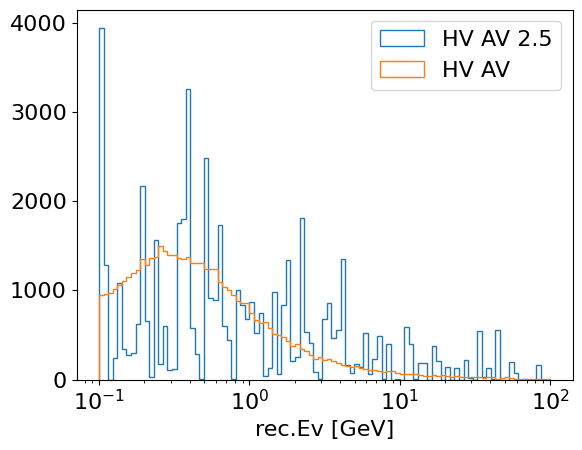

In [764]:
pl.Config.set_tbl_cols(100)
logbins = np.logspace(np.log10(0.1),np.log10(100),100)
print(E.filter(pl.col('Flavour')==12).select(
    pl.col("rec.event"),
    pl.col("rec.cvnnumu"),
    pl.col("rec.Ev"),
    pl.col("rec.Ev_reco"),
    pl.col("rec.Ev_reco_numu"),
    pl.col("rec.Ev_reco_nue"),
    pl.col("rec.muon_contained")
    )
)


plt.hist(df["rec.Ev"], bins=logbins, log=False, histtype='step', label='HV AV 2.5');
plt.hist(dfold["rec.Ev"], bins=logbins, log=False, histtype='step', label='HV AV');
plt.xlabel('rec.Ev [GeV]')
plt.xscale('log')
plt.legend()

17027


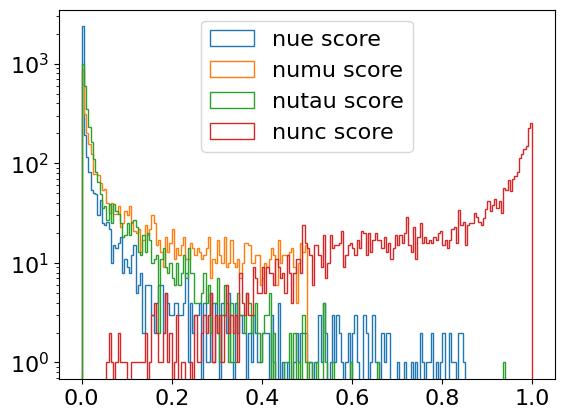

In [676]:
cvnsum = df.with_columns(
    score=pl.sum('rec.cvnnue','rec.cvnnumu', 'rec.cvnnutau','rec.cvnnc')
)

cvnsum = cvnsum.filter(pl.col('rec.isCC')==True).filter((pl.col('rec.cvnnumu')<0.5) & (pl.col('rec.cvnnue')<0.85))
print(len(cvnsum))
pdg=14
# plt.hist(cvnsum.filter(pl.col('rec.nuPDG')==pdg)['score'],       bins=200,range=(0,1),histtype='step',log=True,label='Sum');
plt.hist(cvnsum.filter(pl.col('rec.nuPDG')==pdg)['rec.cvnnue'],  bins=200,range=(0,1),histtype='step',log=True,label='nue score');
plt.hist(cvnsum.filter(pl.col('rec.nuPDG')==pdg)['rec.cvnnumu'], bins=200,range=(0,1),histtype='step',log=True,label='numu score');
plt.hist(cvnsum.filter(pl.col('rec.nuPDG')==pdg)['rec.cvnnutau'],bins=200,range=(0,1),histtype='step',log=True,label='nutau score');
plt.hist(cvnsum.filter(pl.col('rec.nuPDG')==pdg)['rec.cvnnc'], bins=200,range=(0,1),histtype='step',log=True,label='nunc score');
plt.legend()


In [1169]:
dftest = dfold.filter((pl.col('rec.Ev')>2) & (pl.col('rec.Ev')<5)).filter(pl.col("rec.isCC")==1)

# dftest = dftest.filter(
#     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
# )
nutotal = len(dftest)
print(f'Total # of events: {nutotal}, which CC: {len(dftest.filter(pl.col("rec.isCC")==1))}')
nue = len(dftest.filter(pl.col("rec.nuPDG").abs() == 12))
numu = len(dftest.filter(pl.col("rec.nuPDG").abs() == 14))
nuereco = len(dftest.filter(pl.col('Flavour')==12))
numureco = len(dftest.filter(pl.col('Flavour')==14))
# nutau = len(dftest.filter(pl.col('Flavour')==16))
nunot = len(dftest.filter(pl.col('Flavour')==0))
print(f'Nue events: {nue*100/nutotal:.2f}%, Reconstructed nue: {nuereco*100/nue:.2f}%')
print(f'Numu events: {numu*100/nutotal:.2f}%, Reconstructed numu: {numureco*100/numu:.2f}%')
# print(f'Reco middle: {nutau*100/nutotal:.2f}%')
print(f'Fail reco: {nunot*100/nutotal:.2f}%')
print(f'Nue or Numu reco: {(nuereco+numureco)*100/nutotal:.2f} %')

Total # of events: 2056, which CC: 2056
Nue events: 51.12%, Reconstructed nue: 45.77%
Numu events: 48.54%, Reconstructed numu: 64.63%
Fail reco: 41.54%
Nue or Numu reco: 54.77 %


In [924]:
    empty_result = pl.DataFrame({ col: [0 for _ in Ebins] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=Ebins))
    # empty_result = empty_result.with_columns(
    #     Ecut = labels
    # )

rec.CVNResult0Neutrons,rec.CVNResult0Pions,rec.CVNResult0Pizeros,rec.CVNResult0Protons,rec.CVNResult1Neutrons,rec.CVNResult1Pions,rec.CVNResult1Pizeros,rec.CVNResult1Protons,rec.CVNResult2Neutrons,rec.CVNResult2Pions,rec.CVNResult2Pizeros,rec.CVNResult2Protons,rec.CVNResultIsAntineutrino,rec.CVNResultNC,rec.CVNResultNNeutrons,rec.CVNResultNPions,rec.CVNResultNPizeros,rec.CVNResultNProtons,rec.CVNResultNue,rec.CVNResultNumu,rec.CVNResultNutau,rec.EVisReco_ND,rec.EVisReco_nue,rec.EVisReco_numu,rec.Ehad_veto,rec.Elep,rec.Elep_reco,rec.Ev,rec.Ev_reco,rec.Ev_reco_nue,rec.Ev_reco_numu,rec.GENIE_ScatteringMode,rec.HadE,rec.HadEVisReco_FD,rec.HadEVisReco_ND,rec.LepE,rec.LepEndpoint.x,rec.LepEndpoint.y,rec.LepEndpoint.z,rec.LepMomX,rec.LepMomY,rec.LepMomZ,rec.LepNuAngle,rec.LepPDG,rec.LongestTrackContNumu,rec.NDMassCorrWeight,rec.NuMomX,rec.NuMomY,rec.NuMomZ,rec.OffAxisFluxBin,…,rec.nd.gar.tracks.pid_fwd..totarraysize,rec.nd.gar.tracks.pid_prob_bkwd..totarraysize,rec.nd.gar.tracks.pid_prob_fwd..totarraysize,rec.nd.gar.trkLen..length,rec.nd.gar.trkLenPerp..length,rec.nd.lar.nshowers,rec.nd.lar.ntracks,rec.nd.lar.showers..length,rec.nd.lar.tracks..length,rec.nd.ntrkmatch,rec.nd.tms.ntracks,rec.nd.tms.tracks..length,rec.nd.trkmatch..length,rec.niem,rec.nik0,rec.nikm,rec.nikp,rec.niother,rec.nipi0,rec.nipim,rec.nipip,rec.nuPDG,rec.nuPDGunosc,rec.nue_pid,rec.numu_pid,rec.nwgt_CrazyFlux,rec.perPOTWeight,rec.pileup_energy,rec.pot,rec.reco_lepton_pdg,rec.reco_nc,rec.reco_nue,rec.reco_numu,rec.reco_q,rec.run,rec.sigma_Elep_reco,rec.sigma_Ev_reco,rec.sigma_nue_pid,rec.sigma_numu_pid,rec.subrun,rec.theta_reco,rec.total_xsSyst_cv_wgt,rec.vtx_x,rec.vtx_y,rec.vtx_z,rec.wgt_CrazyFlux..length,rec.xsSyst_wgt..length,rec.xsSyst_wgt.elems..totarraysize,Flavour,Ecut
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.75
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.991667
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.233333
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.475
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.716667
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.958333
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.441667
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,